In [66]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math
import random


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

### Read data ###

In [67]:
df = pd.read_csv('./Bitcoin Historical Data.csv')

In [68]:
def convert_to_number(price_str):
    price_str = price_str.replace(",", "")  # Remove any commas
    if 'K' in price_str:
        return float(price_str.replace('K', '')) * 1000
    elif 'M' in price_str:
        return float(price_str.replace('M', '')) * 1000000
    elif 'B' in price_str:
        return float(price_str.replace('B', '')) * 1000000000
    elif '%' in price_str:
        return float(price_str.replace('%', '')) / 100
    else:
        return float(price_str)

In [69]:
df['Date']  = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)
df['Vol.']   = df['Vol.'].apply(convert_to_number)
df.rename(columns={'Vol.': 'Vol'}, inplace=True)
df['Change %'] = df['Change %'].apply(convert_to_number)
df.rename(columns={'Change %': 'Change'}, inplace=True)
df['Price'] = df['Price'].apply(convert_to_number)
df['Open']  = df['Open'].apply(convert_to_number)
df['High']  = df['High'].apply(convert_to_number)
df['Low']   = df['Low'].apply(convert_to_number)

In [70]:
df.sort_index(ascending=True, inplace=True)

In [71]:
df.head()

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2019-03-01,3821.9,3816.7,3855.8,3816.4,1740000.0,0.0014
2019-03-02,3823.1,3821.9,3843.2,3783.6,1610000.0,0.0003
2019-03-03,3809.5,3823.2,3836.6,3789.7,1510000.0,-0.0036
2019-03-04,3715.9,3809.7,3828.4,3681.8,2850000.0,-0.0245
2019-03-05,3857.2,3715.9,3873.2,3705.7,3820000.0,0.0380


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1920 non-null   float64
 1   Open    1920 non-null   float64
 2   High    1920 non-null   float64
 3   Low     1920 non-null   float64
 4   Vol     1920 non-null   float64
 5   Change  1920 non-null   float64
dtypes: float64(6)
memory usage: 105.0 KB


### Descriptive statistic ###

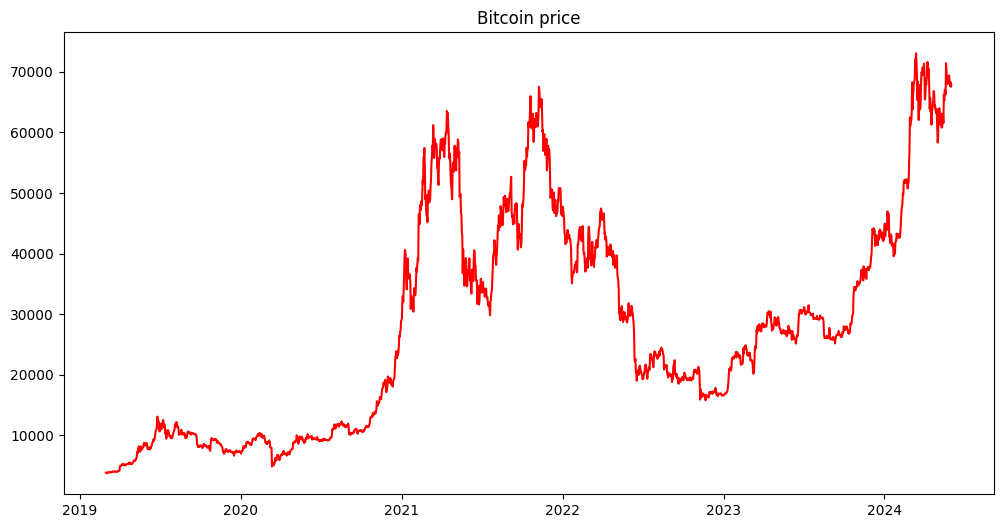

In [73]:
plt.figure(figsize=(12,6))
plt.plot(df["Price"], color='red')
plt.title('Bitcoin price')
plt.show()

### Preprocess data ###

In [74]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

### Parameter ###

In [107]:
window_size = 10
feature_dim = 5
ratio='8:2'
train_size = 0.8

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data ###

In [76]:
train_index = int(len(df)*train_size)
print('train index: ',train_index)

train index:  1536


In [77]:
df_train = df.iloc[:train_index]
df_test  = df[train_index:]

index_30 = random.randint(0, len(df) - 100)
index_60 =random.randint(0, len(df) - 100)
index_90 =random.randint(0, len(df) - 100)

df_30 = df.iloc[index_30: index_30+30]
df_60 = df.iloc[index_60: index_60+60]
df_90 = df.iloc[index_90: index_90+90]

date_range_30 = pd.date_range(start='2024-06-02', end='2024-07-02', periods=30)
date_range_60 = pd.date_range(start='2024-06-02', end='2024-08-01', periods=60)
date_range_90 = pd.date_range(start='2024-02-06', end='2024-08-31', periods=90)

df_30.index = date_range_30.date
df_60.index = date_range_60.date
df_90.index = date_range_90.date

print('df_train.shape: ',df_train.shape)
print('df_test.shape: ',df_test.shape)
print('df_30.shape: ',df_30.shape)
print('df_60.shape: ',df_60.shape)
print('df_90.shape: ',df_90.shape)

df_train.shape:  (1536, 9)
df_test.shape:  (384, 9)
df_30.shape:  (30, 9)
df_60.shape:  (60, 9)
df_90.shape:  (90, 9)


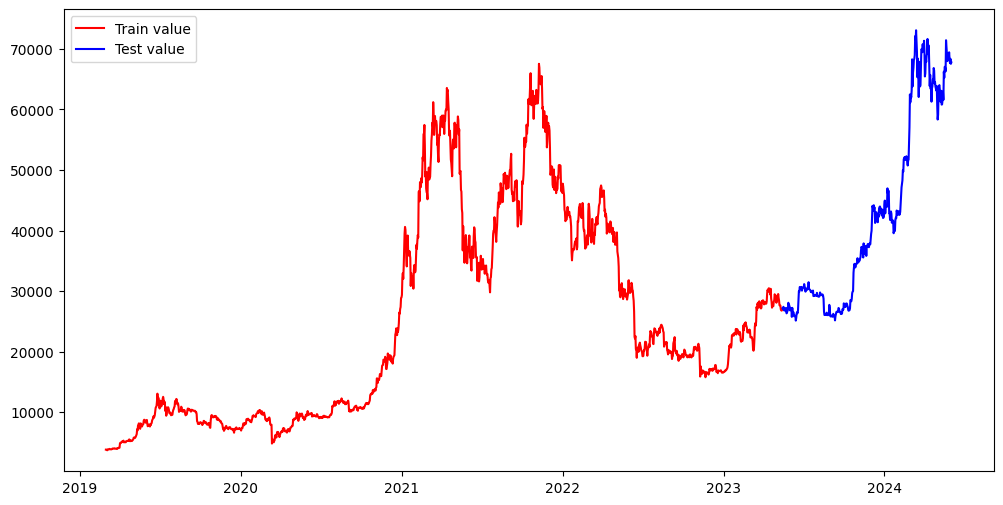

In [78]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train value')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']),color='blue' ,label ='Test value')
plt.legend()
plt.show()

In [79]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_30_scaled = scaler.transform(df_30)
df_60_scaled = scaler.transform(df_60)
df_90_scaled = scaler.transform(df_90)


df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)
df_30_scaled = pd.DataFrame(df_30_scaled,index =df_30.index,columns=df_30.columns)
df_60_scaled = pd.DataFrame(df_60_scaled,index =df_60.index,columns=df_60.columns)
df_90_scaled = pd.DataFrame(df_90_scaled,index =df_90.index,columns=df_90.columns)

In [80]:
X_train_scale = df_train_scaled.drop(columns=['Price'])
y_train_scale = df_train_scaled['Price']

X_test_scale  = df_test_scaled.drop(columns=['Price'])
y_test_scale  = df_test_scaled['Price']

X_30_scale = df_30_scaled.drop(columns=['Price'])
y_30_scale = df_30_scaled['Price']

X_60_scale = df_60_scaled.drop(columns=['Price'])
y_60_scale = df_60_scaled['Price']

X_90_scale = df_90_scaled.drop(columns=['Price'])
y_90_scale = df_90_scaled['Price']

In [81]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)
print('\nX_30_scale shape: ',X_30_scale.shape)
print('y_30_scale shape: ',y_30_scale.shape)
print('\nX_60_scale shape: ',X_60_scale.shape)
print('y_60_scale shape: ',y_60_scale.shape)
print('\nX_90_scale shape: ',X_90_scale.shape)
print('y_90_scale shape: ',y_90_scale.shape)

X_train_scale shape:  (1536, 8)
y_train_scale shape:  (1536,)

X_test_scale shape:  (384, 8)
y_test_scale shape:  (384,)

X_30_scale shape:  (30, 8)
y_30_scale shape:  (30,)

X_60_scale shape:  (60, 8)
y_60_scale shape:  (60,)

X_90_scale shape:  (90, 8)
y_90_scale shape:  (90,)


### Linear Regression ###

In [82]:
X_train_lr = X_train_scale
y_train_lr = y_train_scale

X_test_lr  = X_test_scale
y_test_lr = y_test_scale

X_30_lr = X_30_scale
X_60_lr = X_60_scale
X_90_lr = X_90_scale

In [83]:
model_LR = LinearRegression()
model_LR.fit(X_train_scale, y_train_scale)

LinearRegression()

In [84]:
pred_test_LR = model_LR.predict(X_test_scale)
pred_30_LR = model_LR.predict(X_30_lr)
pred_60_LR = model_LR.predict(X_60_lr)
pred_90_LR = model_LR.predict(X_90_lr)

In [85]:
mape = mean_absolute_percentage_error(y_test_scale, pred_test_LR)
mae = mean_absolute_error(y_test_scale,pred_test_LR)
mse = mean_squared_error(y_test_scale, pred_test_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.005546285433510423
Mean Absolute Error: 0.0037154002999324914
Root Mean Squared Error: 0.0058364438976952265


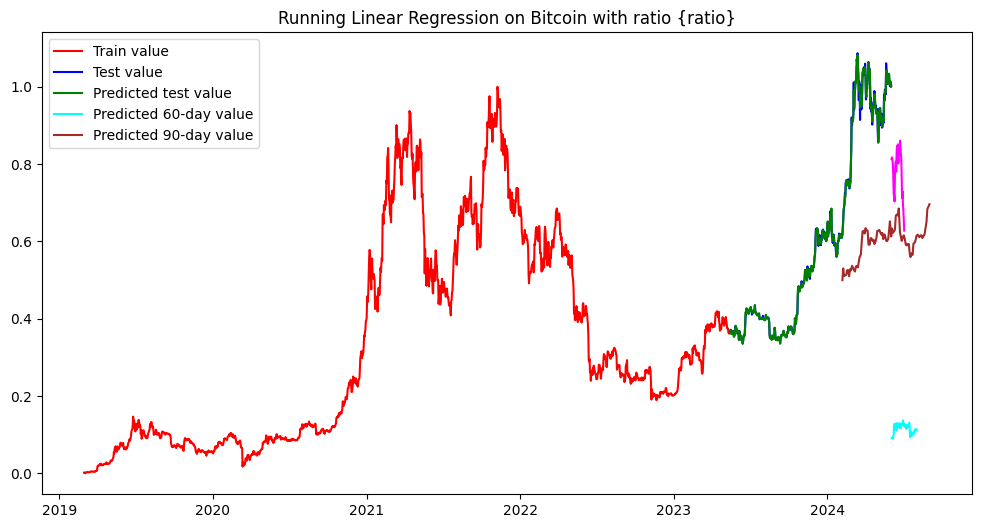

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_lr),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_lr), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LR.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(),pd.DataFrame(pred_30_LR.reshape(-1)),color='magenta')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_LR.reshape(-1)), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_LR.reshape(-1)), color='brown', label='Predicted 90-day value')
plt.title(f"Running Linear Regression on Bitcoin with ratio {ratio}")
plt.legend()
plt.show()

### GRU ###

In [89]:
X_train_GRU = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_GRU = y_test_scale.values

X_test_GRU = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_GRU = y_train_scale.values

X_30_GRU = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_GRU = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_GRU = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [90]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons,  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [91]:
model_GRU = build_GRU_model(
    (X_train_GRU.shape[1], X_train_GRU.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [92]:
history = model_GRU.fit(
    X_train_GRU, y_train_GRU, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [93]:
pred_test_GRU = model_GRU.predict(X_test_GRU)
pred_30_GRU = model_GRU.predict(X_30_GRU)
pred_60_GRU = model_GRU.predict(X_60_GRU)
pred_90_GRU = model_GRU.predict(X_90_GRU)

3/3 [==============================] - 0s 3ms/step


In [100]:
mape = mean_absolute_percentage_error(y_test_GRU, pred_test_GRU)
mae = mean_absolute_error(y_test_GRU,pred_test_GRU)
mse = mean_squared_error(y_test_GRU, pred_test_GRU)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.01755451461960219
Mean Absolute Error: 0.015067970730722758
Root Mean Squared Error: 0.025709528414077358


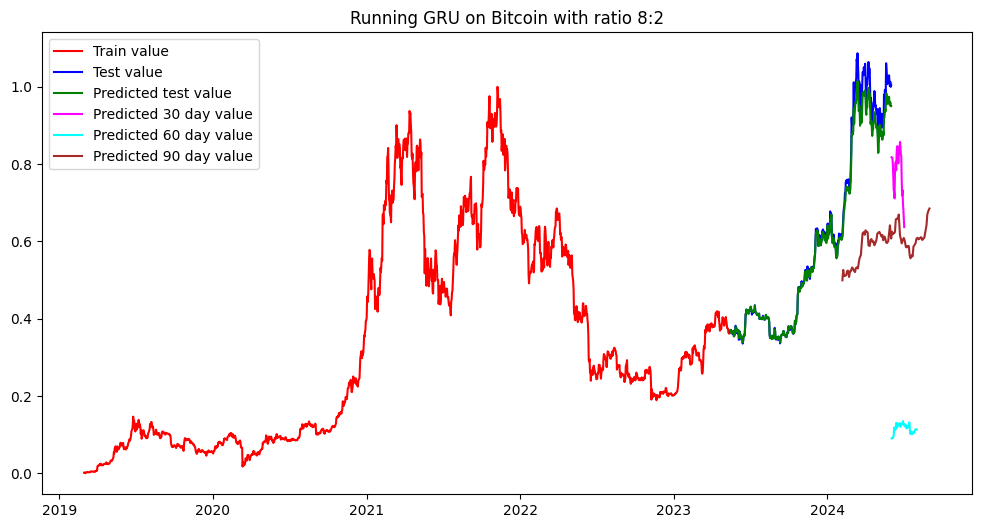

In [109]:

plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_GRU),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_GRU), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_GRU.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_GRU.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_GRU.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_GRU.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title(f"Running GRU on Bitcoin with ratio {ratio}")
plt.legend()
plt.show()

### RNN ###

In [97]:
X_train_RNN = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_RNN = y_test_scale.values

X_test_RNN = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_RNN = y_train_scale.values

X_30_RNN = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_RNN = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_RNN = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [94]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [98]:
model_RNN = build_RNN_model((X_train_RNN.shape[1],X_train_RNN.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [103]:
history = model_RNN.fit(
    X_train_RNN, y_train_RNN, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [104]:
pred_test_RNN = model_RNN.predict(X_test_RNN)
pred_30_RNN = model_RNN.predict(X_30_RNN)
pred_60_RNN = model_RNN.predict(X_60_RNN)
pred_90_RNN = model_RNN.predict(X_90_RNN)

3/3 [==============================] - 0s 3ms/step


In [105]:
mape = mean_absolute_percentage_error(y_test_RNN, pred_test_RNN)
mae = mean_absolute_error(y_test_RNN,pred_test_RNN)
mse = mean_squared_error(y_test_RNN, pred_test_RNN)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.006823004481684525
Mean Absolute Error: 0.00519850745448601
Root Mean Squared Error: 0.008202919785422081


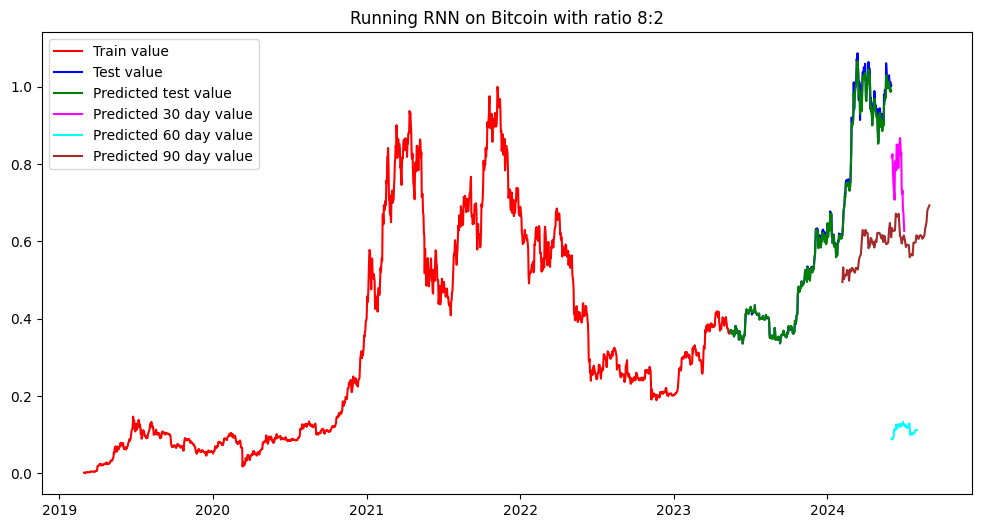

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_RNN),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_RNN), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_RNN.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_RNN.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_RNN.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_RNN.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title(f'Running RNN on Bitcoin with ratio {ratio}')
plt.legend()
plt.show()

### LSTM ###

In [111]:
X_train_LSTM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_LSTM  = y_test_scale.values

X_test_LSTM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_LSTM  = y_train_scale.values

X_30_LSTM = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_LSTM = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_LSTM = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [112]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [113]:
model_LSTM = build_lstm_model(
    (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [114]:
history = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [115]:
pred_test_LSTM = model_LSTM.predict(X_test_LSTM)
pred_30_LSTM = model_LSTM.predict(X_30_RNN)
pred_60_LSTM = model_LSTM.predict(X_60_RNN)
pred_90_LSTM = model_LSTM.predict(X_90_RNN)

3/3 [==============================] - 0s 4ms/step


In [116]:
mape = mean_absolute_percentage_error(y_test_LSTM, pred_test_LSTM)
mae = mean_absolute_error(y_test_LSTM,pred_test_LSTM)
mse = mean_squared_error(y_test_LSTM, pred_test_LSTM)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.0358528027193546
Mean Absolute Error: 0.027996273383207704
Root Mean Squared Error: 0.041105649914608904


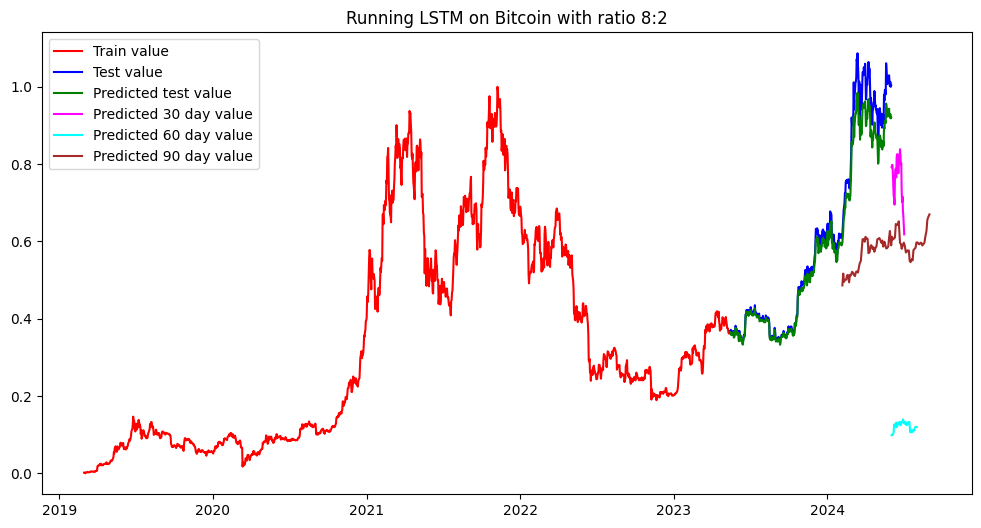

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_LSTM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_LSTM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LSTM.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_LSTM.reshape(-1)), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_LSTM.reshape(-1)), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_LSTM.reshape(-1)), color='brown', label='Predicted 90 day value')
plt.title(f"Running LSTM on Bitcoin with ratio {ratio}")
plt.legend()
plt.show()

### AUTOFORMER ###

### SARIMAX ###

### STACKING MODELS ###

In [132]:
X_train_SM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_train_SM  = y_train_scale.values

X_test_SM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_test_SM  = y_test_scale.values

X_30_SM = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_SM = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_SM = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [133]:
print('X_train_SM shape: ',X_train_SM.shape)
print('y_train_SM shape: ',y_train_SM.shape)
print('X_test_SM shape: ',X_test_SM.shape)
print('y_test_SM shape: ',y_test_SM.shape)

X_train_SM shape:  (1536, 1, 8)
y_train_SM shape:  (1536,)
X_test_SM shape:  (384, 1, 8)
y_test_SM shape:  (384,)


In [134]:
kf = KFold(n_splits=4,shuffle=False)

#### Base models ####

In [135]:
base_model_GRU = build_GRU_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [136]:
base_model_LSTM = build_lstm_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

##### First base model (GRU) #####

In [137]:
X_train_GRU_stacking = pd.DataFrame()
y_30_GRU_stacking = {}
y_60_GRU_stacking = {}
y_90_GRU_stacking = {}
y_val_GRU_stacking = {}
y_train_GRU_stacking = pd.DataFrame()
y_test_SM_GRU={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_GRU.predict(X_test_fold)
    y_test_SM_GRU[f'y_test_SM_GRU_{i}'] = base_model_GRU.predict(X_test_SM)
    y_30_GRU_stacking[f'y_30_GRU_stacking_{i}'] = base_model_GRU.predict(X_30_SM)
    y_60_GRU_stacking[f'y_60_GRU_stacking_{i}'] = base_model_GRU.predict(X_60_SM)
    y_90_GRU_stacking[f'y_90_GRU_stacking_{i}'] = base_model_GRU.predict(X_90_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_GRU_stacking = pd.concat([X_train_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_GRU_stacking = pd.concat([y_train_GRU_stacking,y_test_fold_df], axis=0, ignore_index=True)

Epoch 1/10
36/36 [==============================] - 2s 3ms/step - loss: 0.2982
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.1645
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - loss: 0.1259
Epoch 4/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0910
Epoch 5/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0583
Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
36/36 [==============================] - 0s 4ms/step - loss: 0.0488
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0479
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - lo

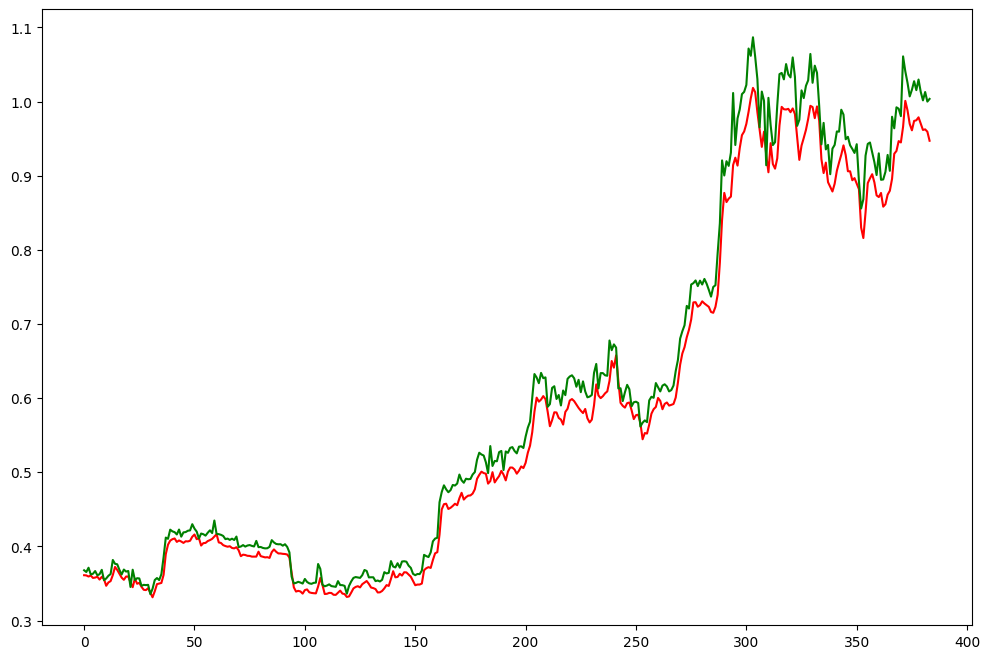

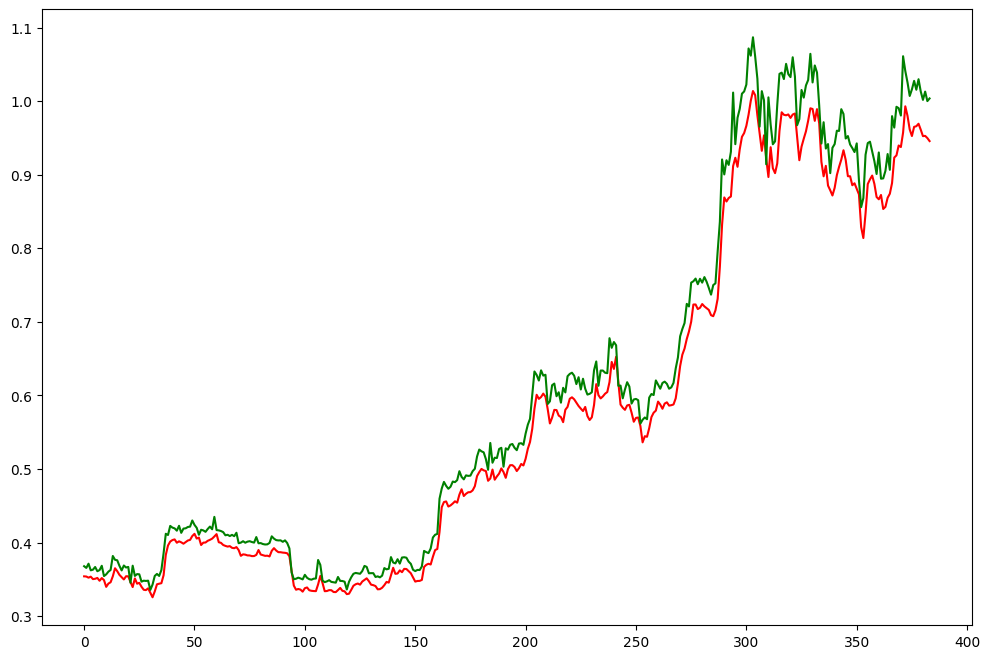

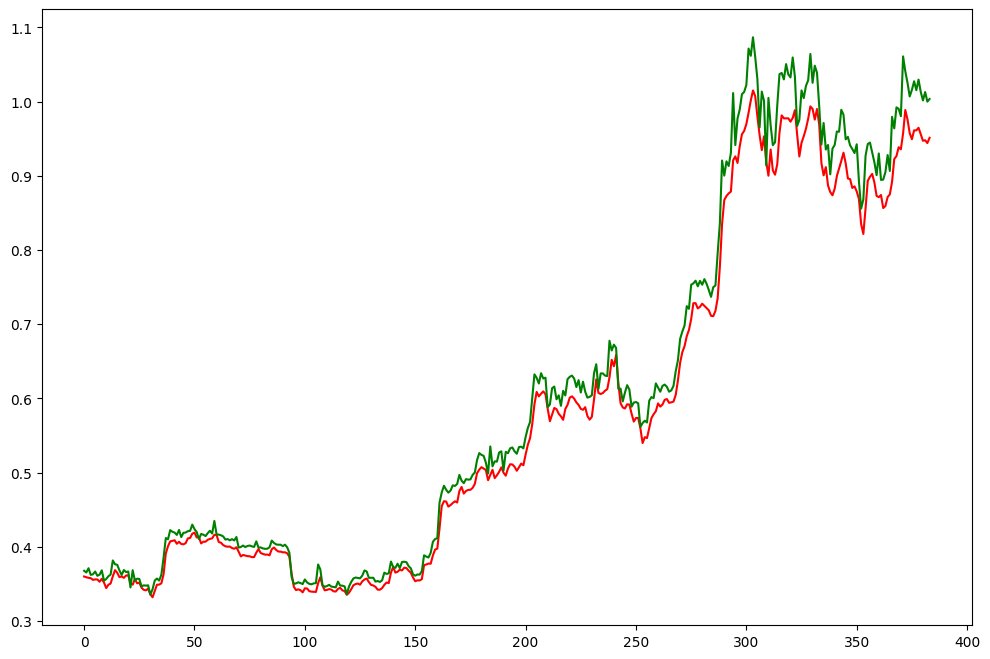

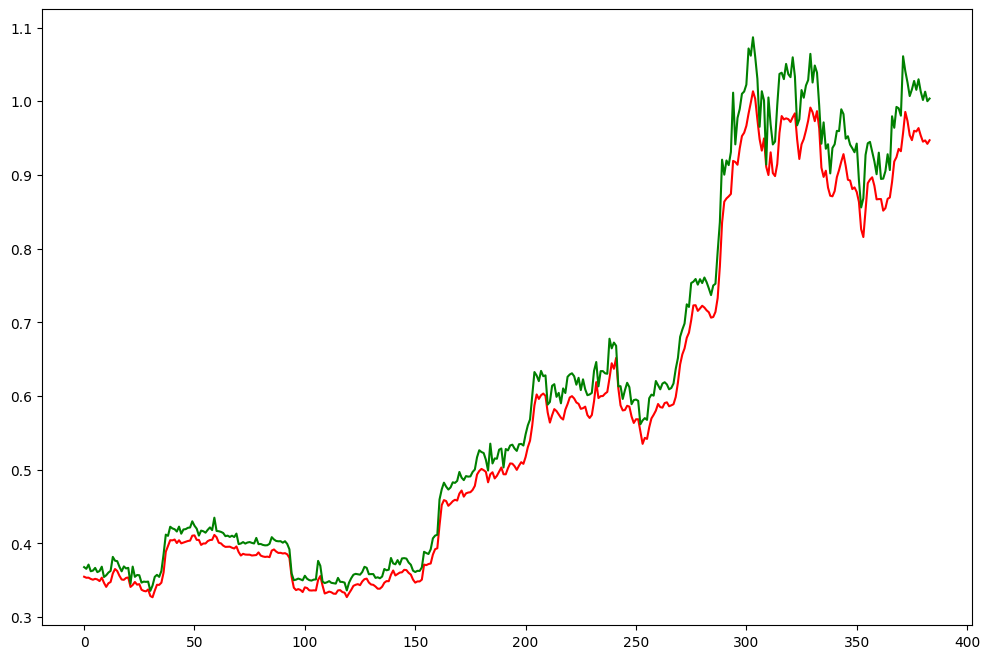

In [138]:
for key in y_test_SM_GRU:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_GRU[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [139]:
num_elements = len(next(iter(y_test_SM_GRU.values())))
test_GRU_average = []
for i in range(num_elements):
    element_sum = sum(y_test_SM_GRU[key][i] for key in y_test_SM_GRU)
    test_GRU_average.append(element_sum / len(y_test_SM_GRU))
test_GRU_average = pd.DataFrame(test_GRU_average)

In [140]:
num_elements = len(next(iter(y_90_GRU_stacking.values())))
GRU_30_average =[]
GRU_60_average =[]
GRU_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_GRU_stacking[key.replace('90','30')][i] for key in y_30_GRU_stacking)
        GRU_30_average.append(element_sum_30 / len(y_30_GRU_stacking))
    if i <60:
        element_sum_60 = sum(y_60_GRU_stacking[key.replace('90','60')][i] for key in y_60_GRU_stacking)
        GRU_60_average.append(element_sum_60 / len(y_60_GRU_stacking))
    element_sum_90 = sum(y_90_GRU_stacking[key][i] for key in y_90_GRU_stacking)
    GRU_90_average.append(element_sum_90 / len(y_90_GRU_stacking))
GRU_30_average = pd.DataFrame(GRU_30_average)
GRU_60_average = pd.DataFrame(GRU_60_average)
GRU_90_average = pd.DataFrame(GRU_90_average)

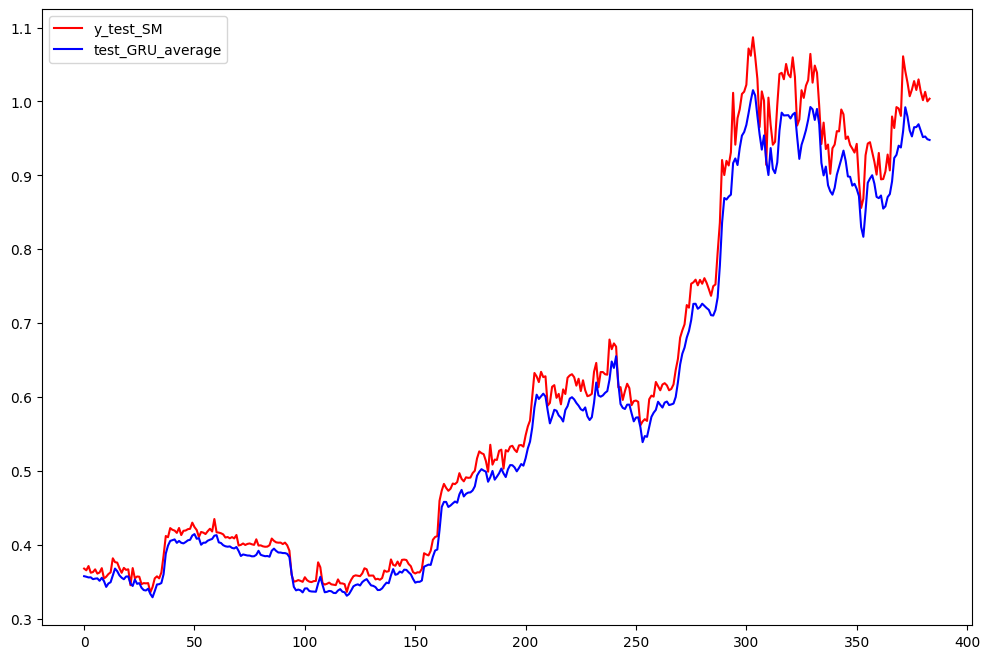

In [142]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_GRU_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

##### Second base model (LSTM) #####

In [144]:
X_train_LSTM_stacking = pd.DataFrame()
y_30_LSTM_stacking = {}
y_60_LSTM_stacking = {}
y_90_LSTM_stacking = {}
y_train_LSTM_stacking = pd.DataFrame()
y_test_SM_LSTM={}
y_val_LSTM_stacking = {}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_LSTM.predict(X_test_fold)
    y_test_SM_LSTM[f'y_test_SM_LSTM_{i}'] = base_model_LSTM.predict(X_test_SM)
    y_30_LSTM_stacking[f'y_30_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_30_SM)
    y_60_LSTM_stacking[f'y_60_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_60_SM)
    y_90_LSTM_stacking[f'y_90_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_90_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_LSTM_stacking = pd.concat([X_train_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_LSTM_stacking = pd.concat([y_train_LSTM_stacking,y_test_fold_df],axis=0,ignore_index=True)

Epoch 1/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0483
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0445
Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0438
Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0430
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 8/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0392
Epoch 9/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0393
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
36/36 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 2/10
36/36 [==============================] - 0s 4ms/step - loss: 0.0342
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - lo

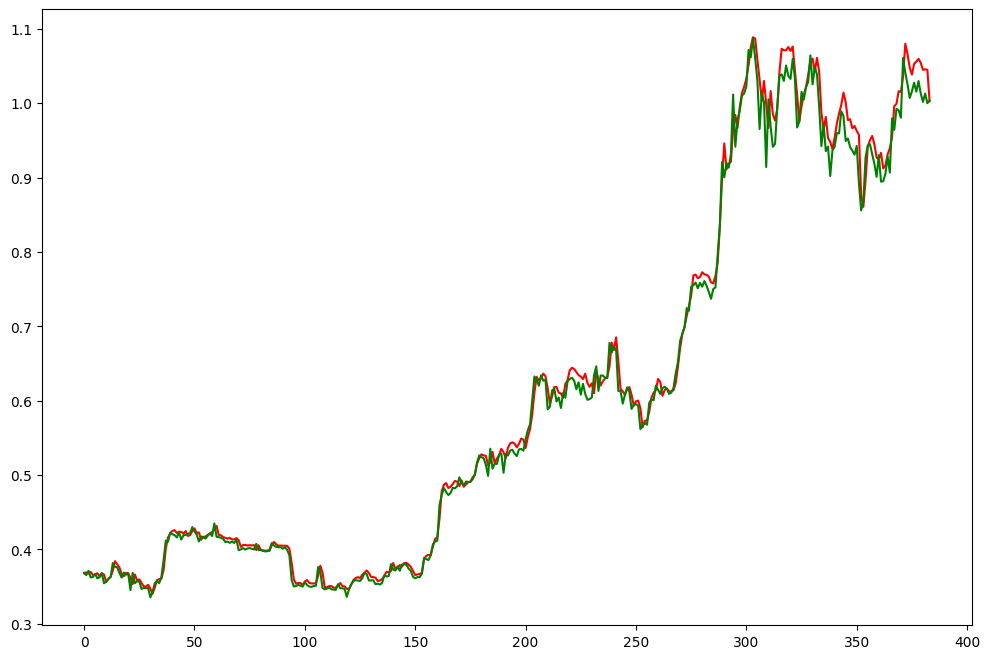

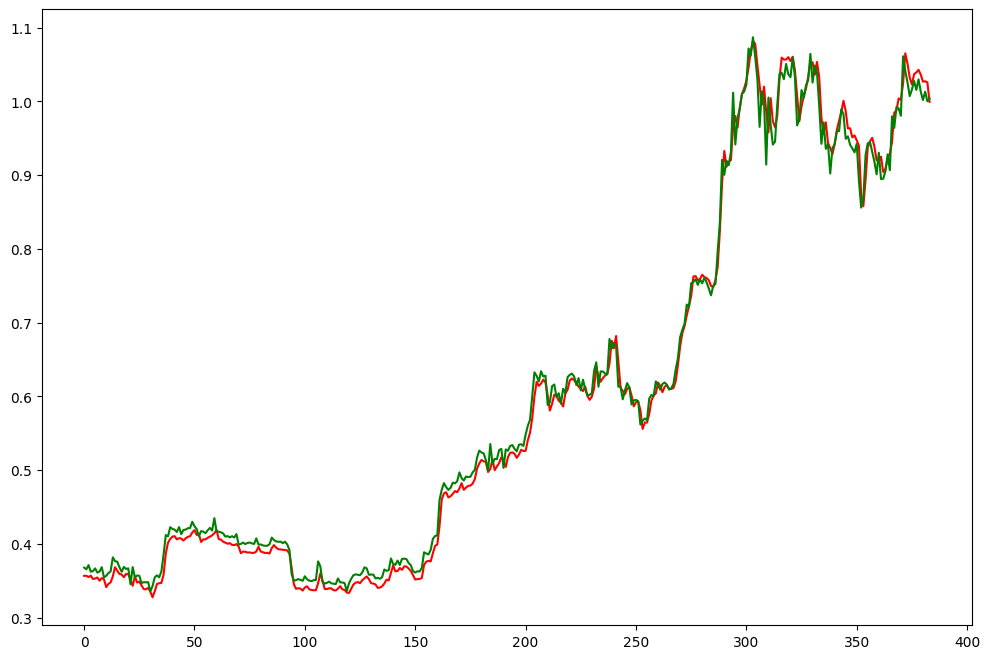

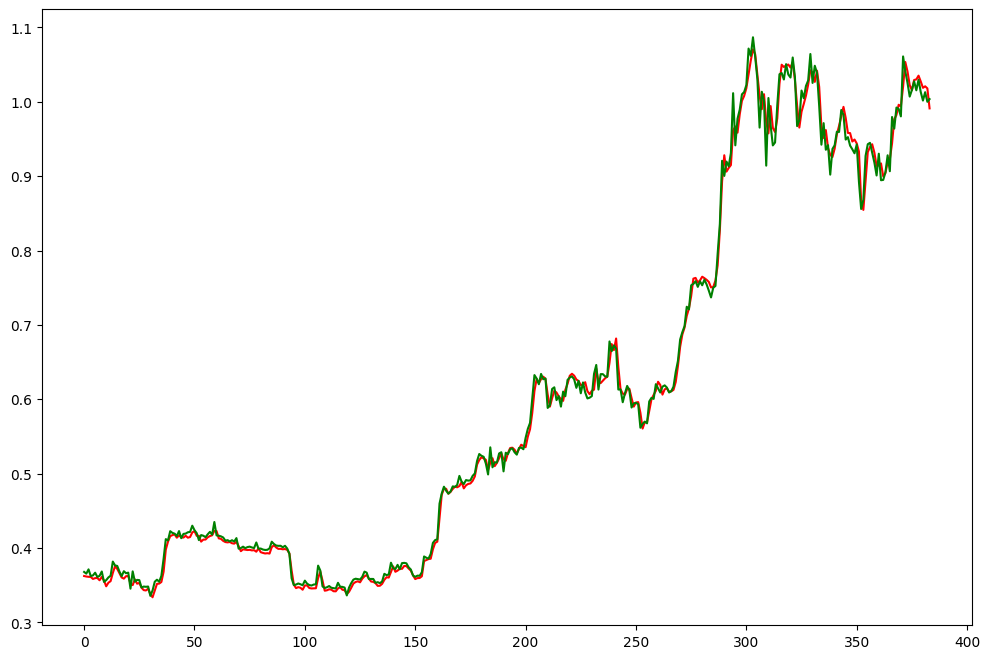

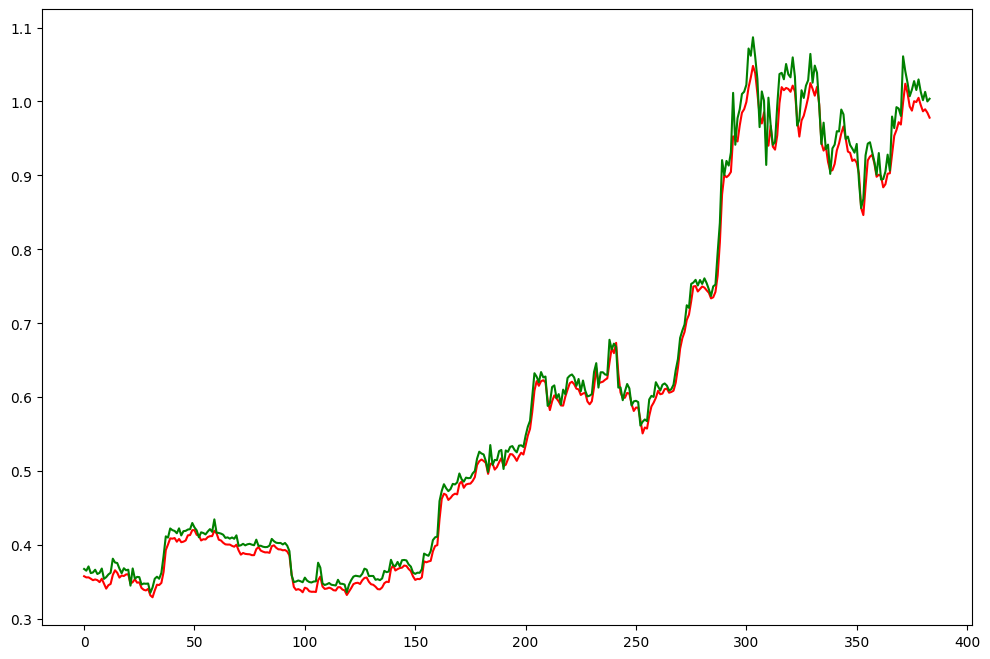

In [145]:
for key in y_test_SM_LSTM:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_LSTM[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [146]:
num_elements = len(next(iter(y_test_SM_LSTM.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(y_test_SM_LSTM[key][i] for key in y_test_SM_LSTM)
    test_LSTM_average.append(element_sum / len(y_test_SM_LSTM))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

In [147]:
num_elements = len(next(iter(y_90_LSTM_stacking.values())))
LSTM_30_average =[]
LSTM_60_average =[]
LSTM_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_LSTM_stacking[key.replace('90','30')][i] for key in y_30_LSTM_stacking)
        LSTM_30_average.append(element_sum_30 / len(y_30_LSTM_stacking))
    if i <60:
        element_sum_60 = sum(y_60_LSTM_stacking[key.replace('90','60')][i] for key in y_60_LSTM_stacking)
        LSTM_60_average.append(element_sum_60 / len(y_60_LSTM_stacking))
    element_sum_90 = sum(y_90_LSTM_stacking[key][i] for key in y_90_LSTM_stacking)
    LSTM_90_average.append(element_sum_90 / len(y_90_LSTM_stacking))
LSTM_30_average = pd.DataFrame(LSTM_30_average)
LSTM_60_average = pd.DataFrame(LSTM_60_average)
LSTM_90_average = pd.DataFrame(LSTM_90_average)

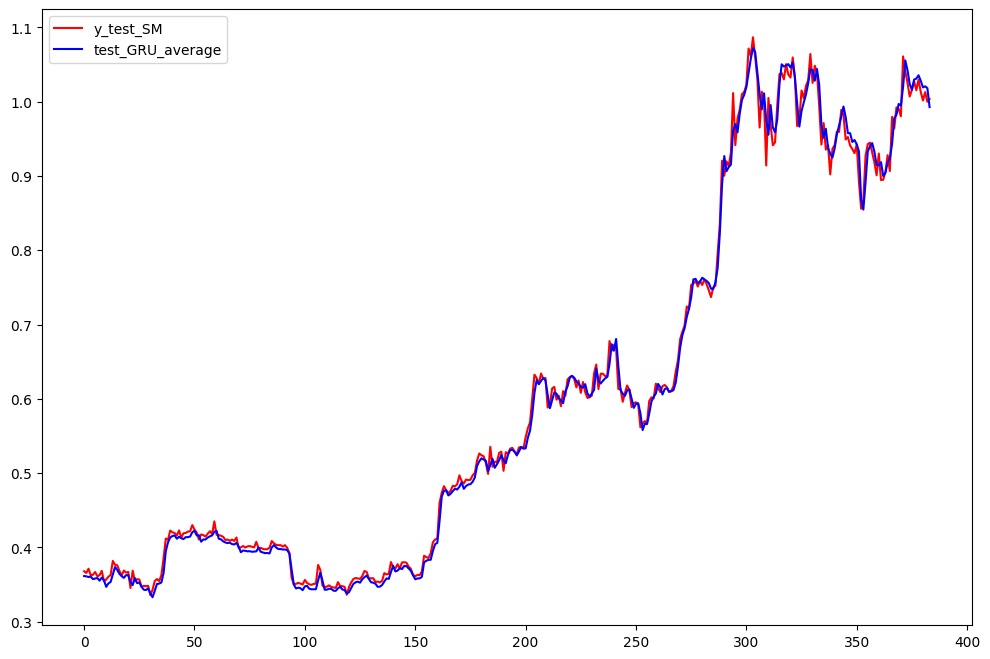

In [150]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_LSTM_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

#### Train dataset for meta model ####

In [155]:
X_train_meta = pd.concat([X_train_GRU_stacking, X_train_LSTM_stacking], axis=1, ignore_index=True)
y_train_meta = y_train_GRU_stacking

#### Test dataset for meta model ####

In [156]:
X_test_meta = pd.concat([test_GRU_average,test_LSTM_average],axis=1, ignore_index=True)

#### Meta model training ####

In [157]:
X_train_meta = X_train_meta.values
y_train_meta = y_train_meta.values.reshape(-1)
X_test_meta  = X_test_meta.values
y_test_meta  = y_test_SM

X_30_meta = pd.concat([GRU_30_average,LSTM_30_average],axis=1, ignore_index=True)
X_60_meta = pd.concat([GRU_60_average,LSTM_60_average],axis=1, ignore_index=True)
X_90_meta = pd.concat([GRU_90_average,LSTM_90_average],axis=1, ignore_index=True)

In [163]:
print('X train shape of meta model: ', X_train_meta.shape)
print('y train shape of meta model: ',y_train_meta.shape)
print('X test shape of meta model', X_test_meta.shape)
print('y test shape of meta model',y_test_meta.shape)

X train shape of meta model:  (1536, 2)
y train shape of meta model:  (1536,)
X test shape of meta model (384, 2)
y test shape of meta model (384,)


In [164]:
meta_model = LinearRegression()
meta_model.fit(X_train_meta, y_train_meta)

LinearRegression()

In [166]:
pred_test_meta = meta_model.predict(X_test_meta)
pred_30_meta = meta_model.predict(X_30_meta)
pred_60_meta = meta_model.predict(X_60_meta)
pred_90_meta = meta_model.predict(X_90_meta)

In [167]:
mape = mean_absolute_percentage_error(y_test_meta, pred_test_meta)
mae = mean_absolute_error(y_test_meta,pred_test_meta)
mse = mean_squared_error(y_test_meta, pred_test_meta)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.01563292304581748
Mean Absolute Error: 0.010573691874701703
Root Mean Squared Error: 0.01558551337150514


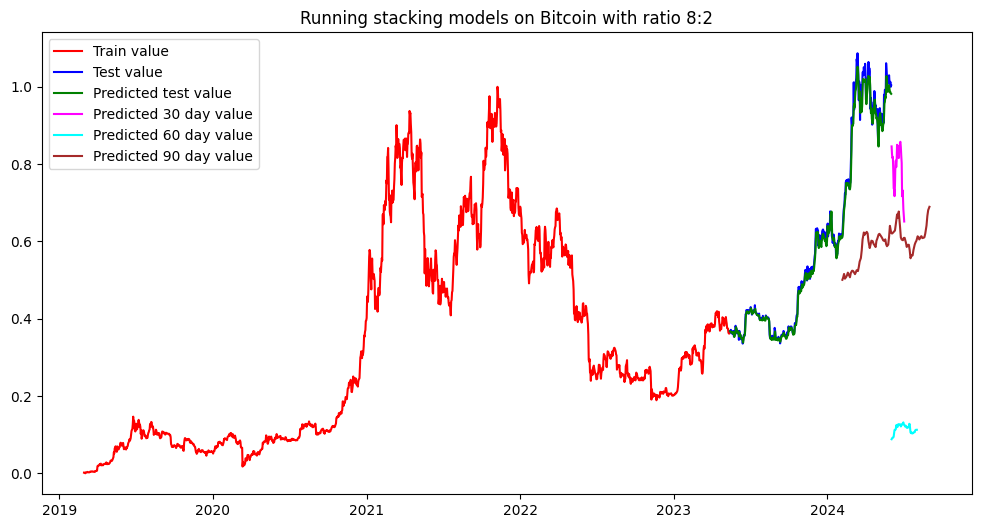

In [168]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_SM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_SM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_meta), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_meta), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_meta), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_meta), color='brown', label='Predicted 90 day value')
plt.title(f"Running stacking models on Bitcoin with ratio {ratio}")
plt.legend()
plt.show()

### ARIMA ###

In [158]:
y_train_ARIMA= y_train_scale

y_test_ARIMA = y_test_scale

In [159]:
model_ARIMA = ARIMA(y_train_ARIMA, order=(3, 0, 3)).fit()

d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [160]:
pred_test_ARIMA = model_ARIMA.forecast(steps=len(y_test_ARIMA))
pred_30_ARIMA = model_ARIMA.forecast(steps = 30)
pred_60_ARIMA = model_ARIMA.forecast(steps = 60)
pred_90_ARIMA = model_ARIMA.forecast(steps = 90)

In [161]:
mape = mean_absolute_percentage_error(y_test_ARIMA, pred_test_ARIMA)
mae = mean_absolute_error(y_test_ARIMA,pred_test_ARIMA)
mse = mean_squared_error(y_test_ARIMA, pred_test_ARIMA)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.33049069340985265
Mean Absolute Error: 0.25635042402700664
Root Mean Squared Error: 0.3574239279626007


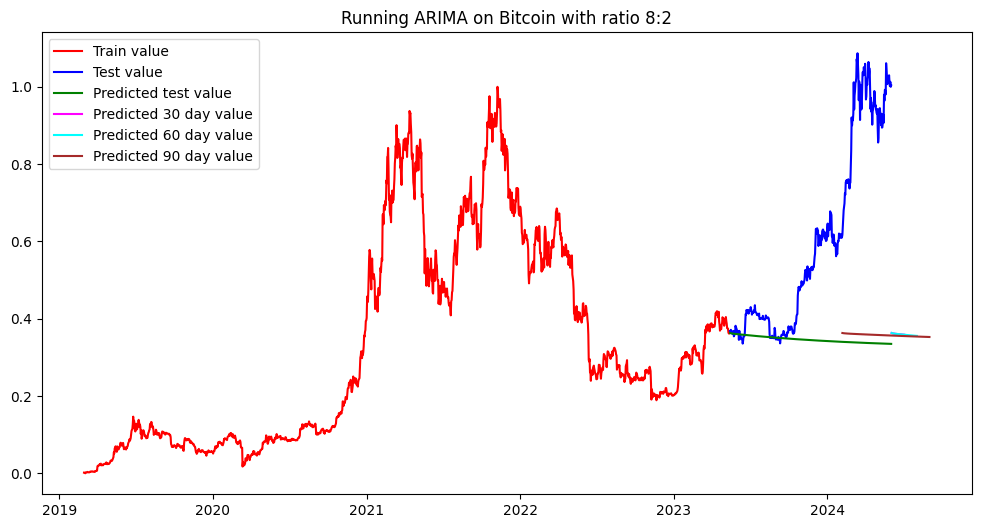

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_ARIMA),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_ARIMA), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_ARIMA), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_ARIMA), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_ARIMA), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_ARIMA), color='brown', label='Predicted 90 day value')
plt.title(f"Running ARIMA on Bitcoin with ratio {ratio}")
plt.legend()
plt.show()